In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(2)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

In [2]:
# arrange 2D matrices as tiles (takes 4D `examples` tensor with dims: rows x cols x tile_height x tile_width)
def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2

    height = rows_count * (tile_height + space_between_tiles) - space_between_tiles
    width = cols_count * (tile_width + space_between_tiles) - space_between_tiles

    img_matrix = np.empty(shape=(height, width))
    img_matrix.fill(np.nan)

    for row in range(rows_count):
        for col in range(cols_count):
            row_ind = (tile_height + space_between_tiles) * row
            col_ind = (tile_height + space_between_tiles) * col
            img_matrix[row_ind:row_ind  + tile_height, col_ind:col_ind + tile_width] = examples[row, col]

    return img_matrix

## MNIST Dataset

Mnist dataset has: 60000 images.
Image dimensions: 28 x 28
Reduce Mnist dataset has: 288 images.


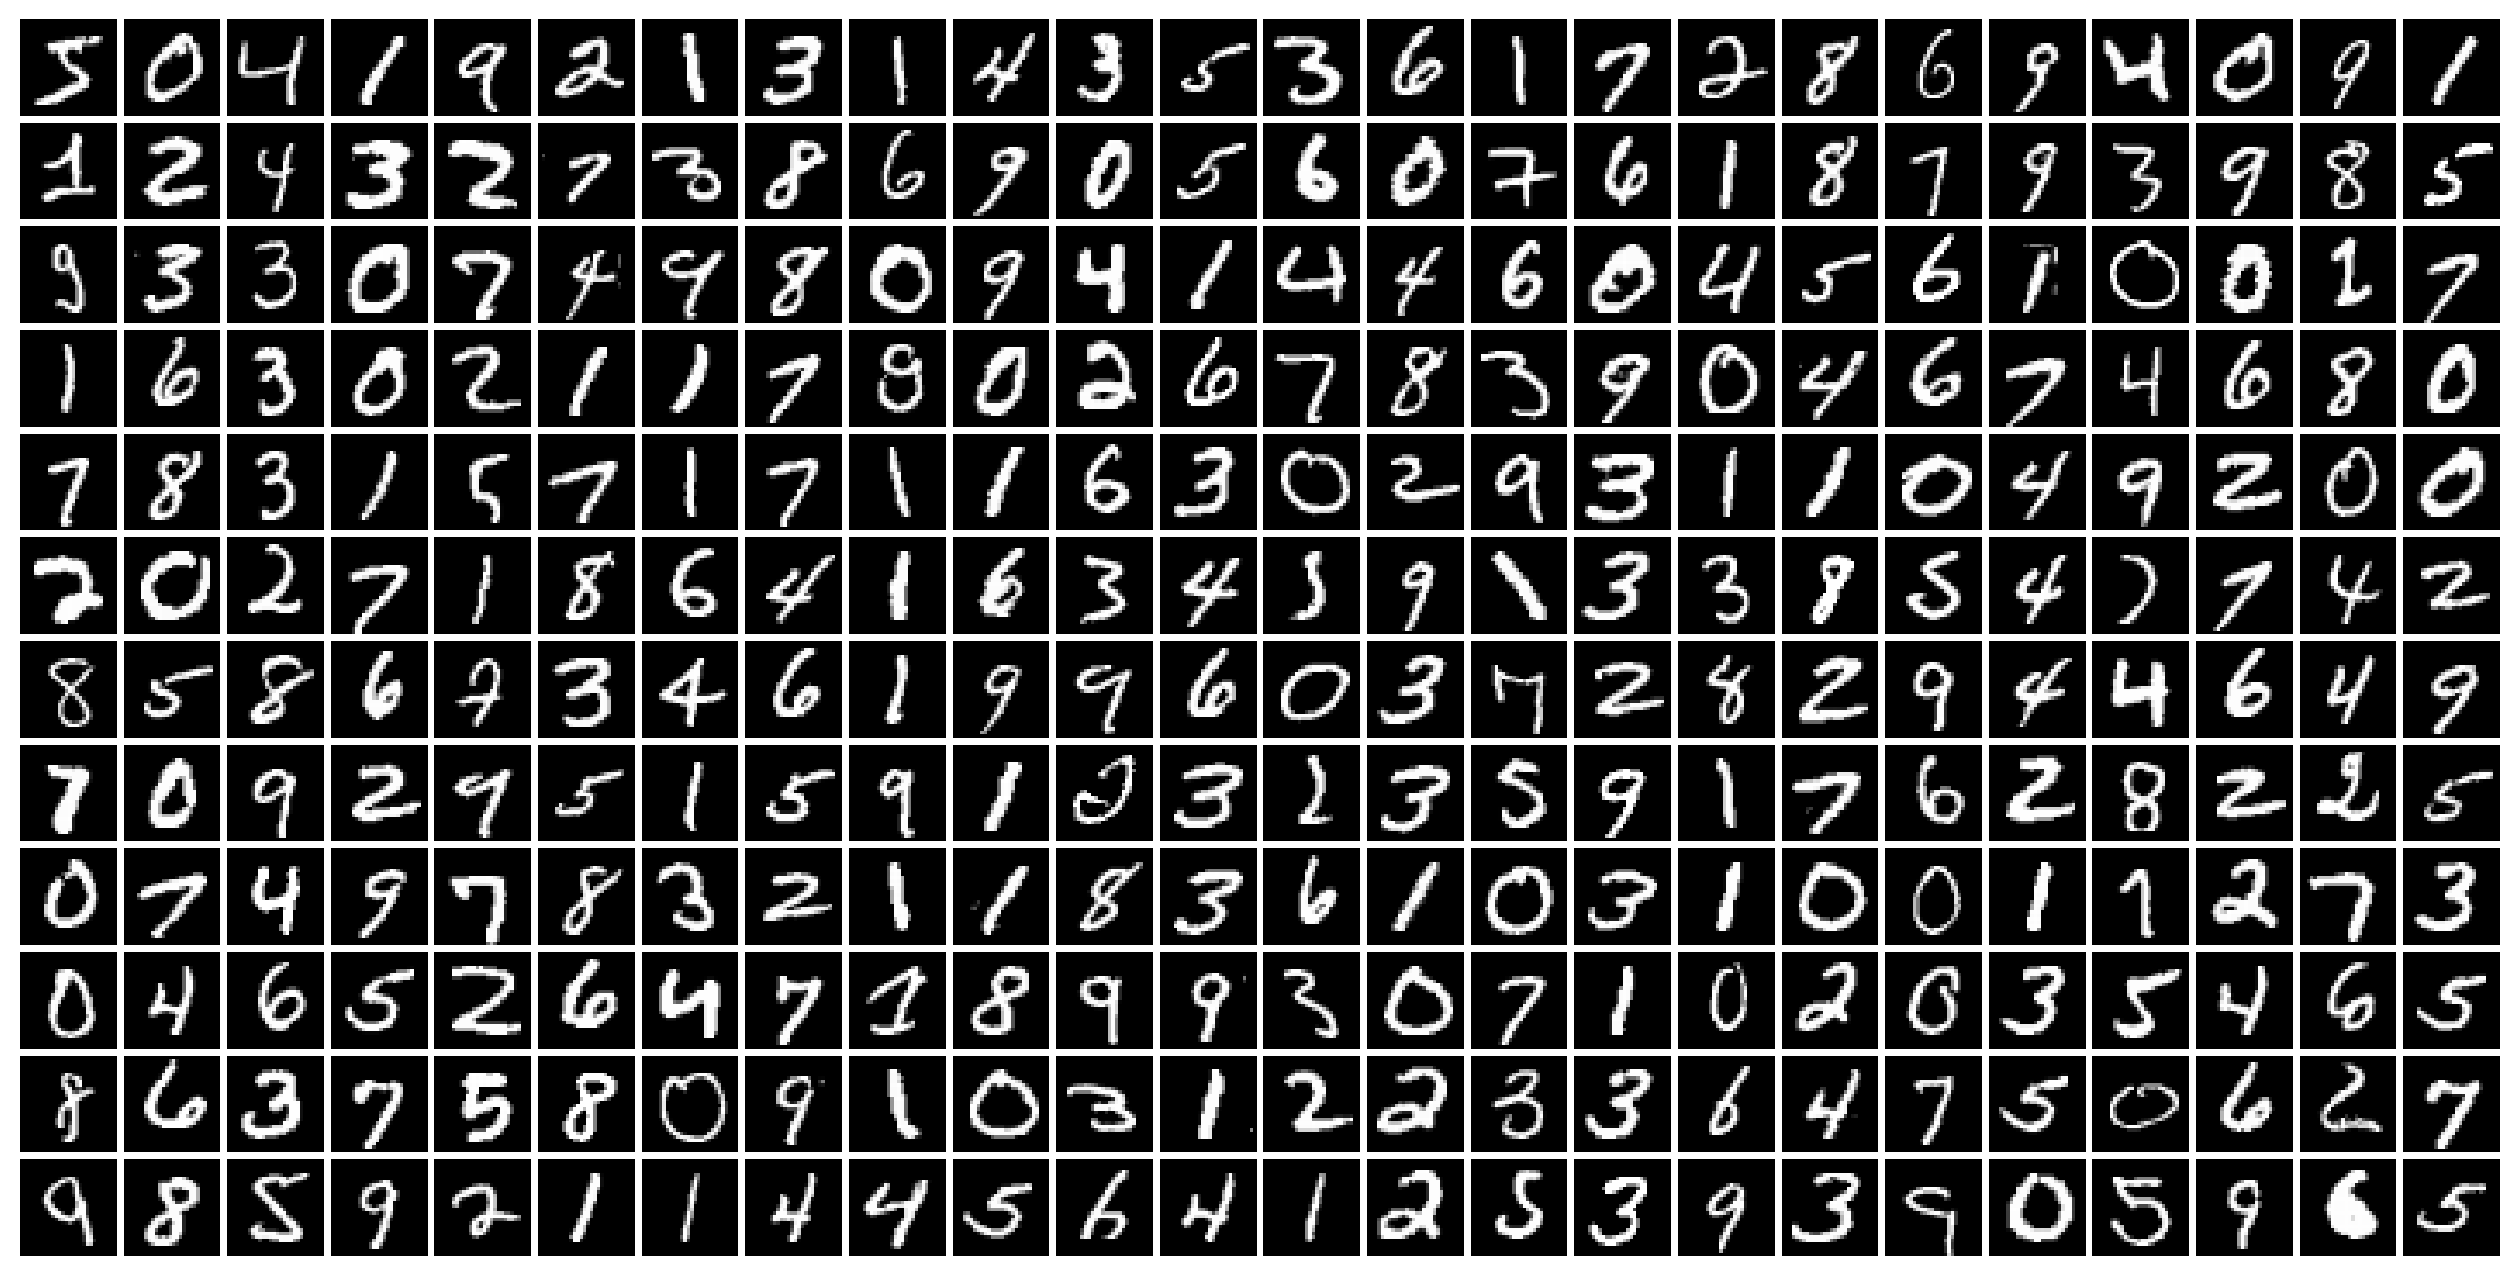

In [3]:
import mnist

print(f"Mnist dataset has: {mnist.train_images().shape[0]} images.")
print(f"Image dimensions: {mnist.train_images().shape[1]} x {mnist.train_images().shape[2]}")

digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
print(f"Reduce Mnist dataset has: {mnist.train_images()[:12*24].shape[0]} images.")

img = tiles(digits)

plt.matshow(img, cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

In [4]:
print(f"Original minst images dtype: {mnist.train_images().dtype}")
X = mnist.train_images().astype(np.float32) / 255.0
y = mnist.train_labels()
X.shape

Original minst images dtype: uint8


(60000, 28, 28)

Reshape `X` so that the last two dimensions are collapsed into single dimension.

In [5]:
X = X.reshape(X.shape[0], -1)

In [6]:
X.shape

(60000, 784)

## Visualizing the distribution of MNIST digits

Add a scatter plot to `plot`, which:
* displys the first two dimensions of `X`,
* includes only these elements from `X` for which `y == i` (i.e. elements from the i-th class),
* includes label (i.e. `i`) in the legend.


In [7]:
def plot_2d_mnist_scatter(X, y):
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        digit_indeces = (y == i)
        dim0 = X[digit_indeces, 0]
        dim1 = X[digit_indeces, 1]
        plot.scatter(dim0, dim1, label = f"Digit {i}")
        

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

### Principal Component Analysis (PCA)

In [8]:
SAMPLES_LIMIT = 2000
print(X.shape)
X_small = X[:SAMPLES_LIMIT]
y_small = y[:SAMPLES_LIMIT]

(60000, 784)


Use PCA function to embed `X_small` in two dimensions. Store the result in `X_pca_embedded`.

In [9]:
from sklearn.decomposition import PCA

print(f"Minst dataset has been reduced from {X.shape[0]} to {X_small.shape[0]} images.")

pca = PCA(n_components = 2)
print(f"Using {pca} to embed X_small in {pca.n_components} dimensions...")
X_pca_embedded = pca.fit_transform(X_small)


Minst dataset has been reduced from 60000 to 2000 images.
Using PCA(n_components=2) to embed X_small in 2 dimensions...


In [10]:
X_pca_embedded.shape

(2000, 2)

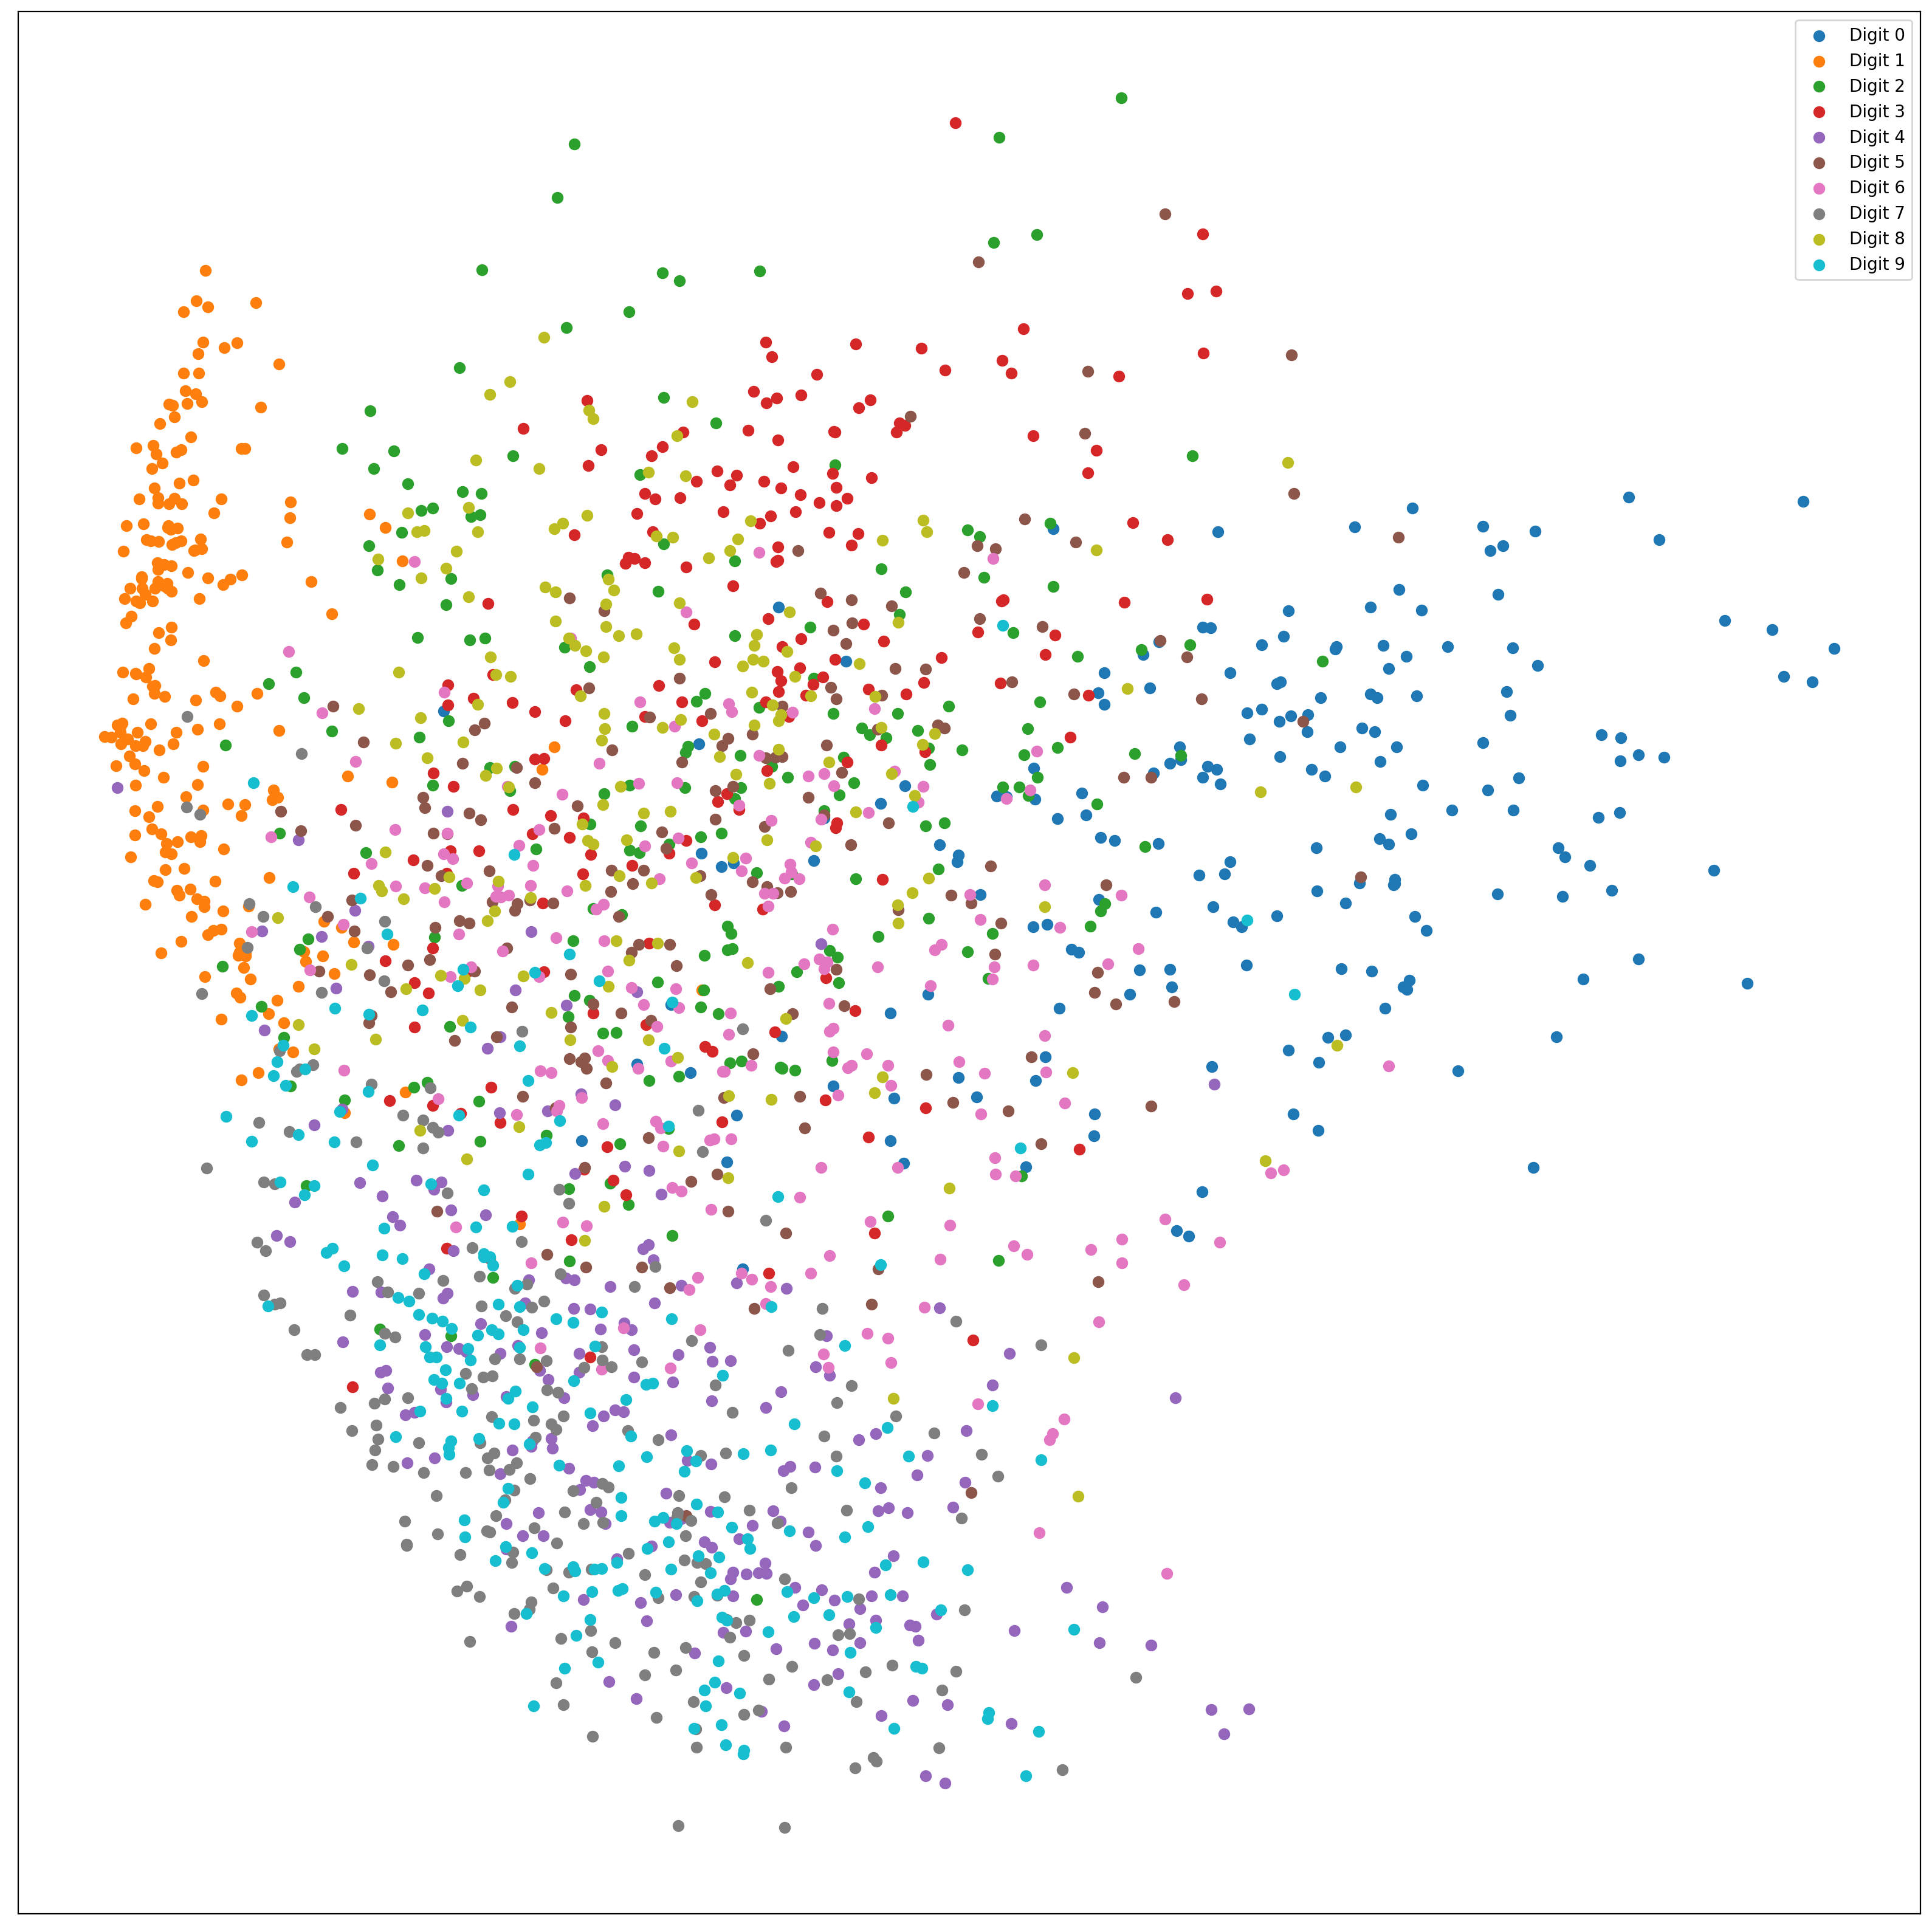

In [11]:
plot_2d_mnist_scatter(X_pca_embedded, y_small)

### T-distributed Stochastic Neighbour Embedding (T-SNE)

Make sure to have a look on this increadible [article on T-SNE](https://distill.pub/2016/misread-tsne/).

Use `T-SNE` function to embed `X_small` in two dimensions. Store the result in `X_tsne_embedded`. <BR>
Use:
 * `n_iter=500` argument to limit the number of T-SNE iterations, 
 * `verbose=2` argument to see a verbose output during embedding.

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=500, verbose=2)
X_tsne_embedded = tsne.fit_transform(X_small)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 1.703s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.528207
[t-SNE] Computed conditional probabilities in 0.205s
[t-SNE] Iteration 50: error = 77.8388290, gradient norm = 0.0137023 (50 iterations in 7.765s)
[t-SNE] Iteration 100: error = 75.6759109, gradient norm = 0.0004194 (50 iterations in 7.198s)
[t-SNE] Iteration 150: error = 75.6410065, gradient norm = 0.0007201 (50 iterations in 8.901s)
[t-SNE] Iteration 200: error = 75.5782776, gradient norm = 0.0006917 (50 iterations in 6.604s)
[t-SNE] Iteration 250: error = 75.5438538, gradient norm = 0.0002524 (50 iterations in 8.201s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.543854
[t-SNE] Iteration 300: error = 1.7901143, gradient norm = 0.0210764 (50 iterations in 6.994s)

In [13]:
X_tsne_embedded.shape

(2000, 2)

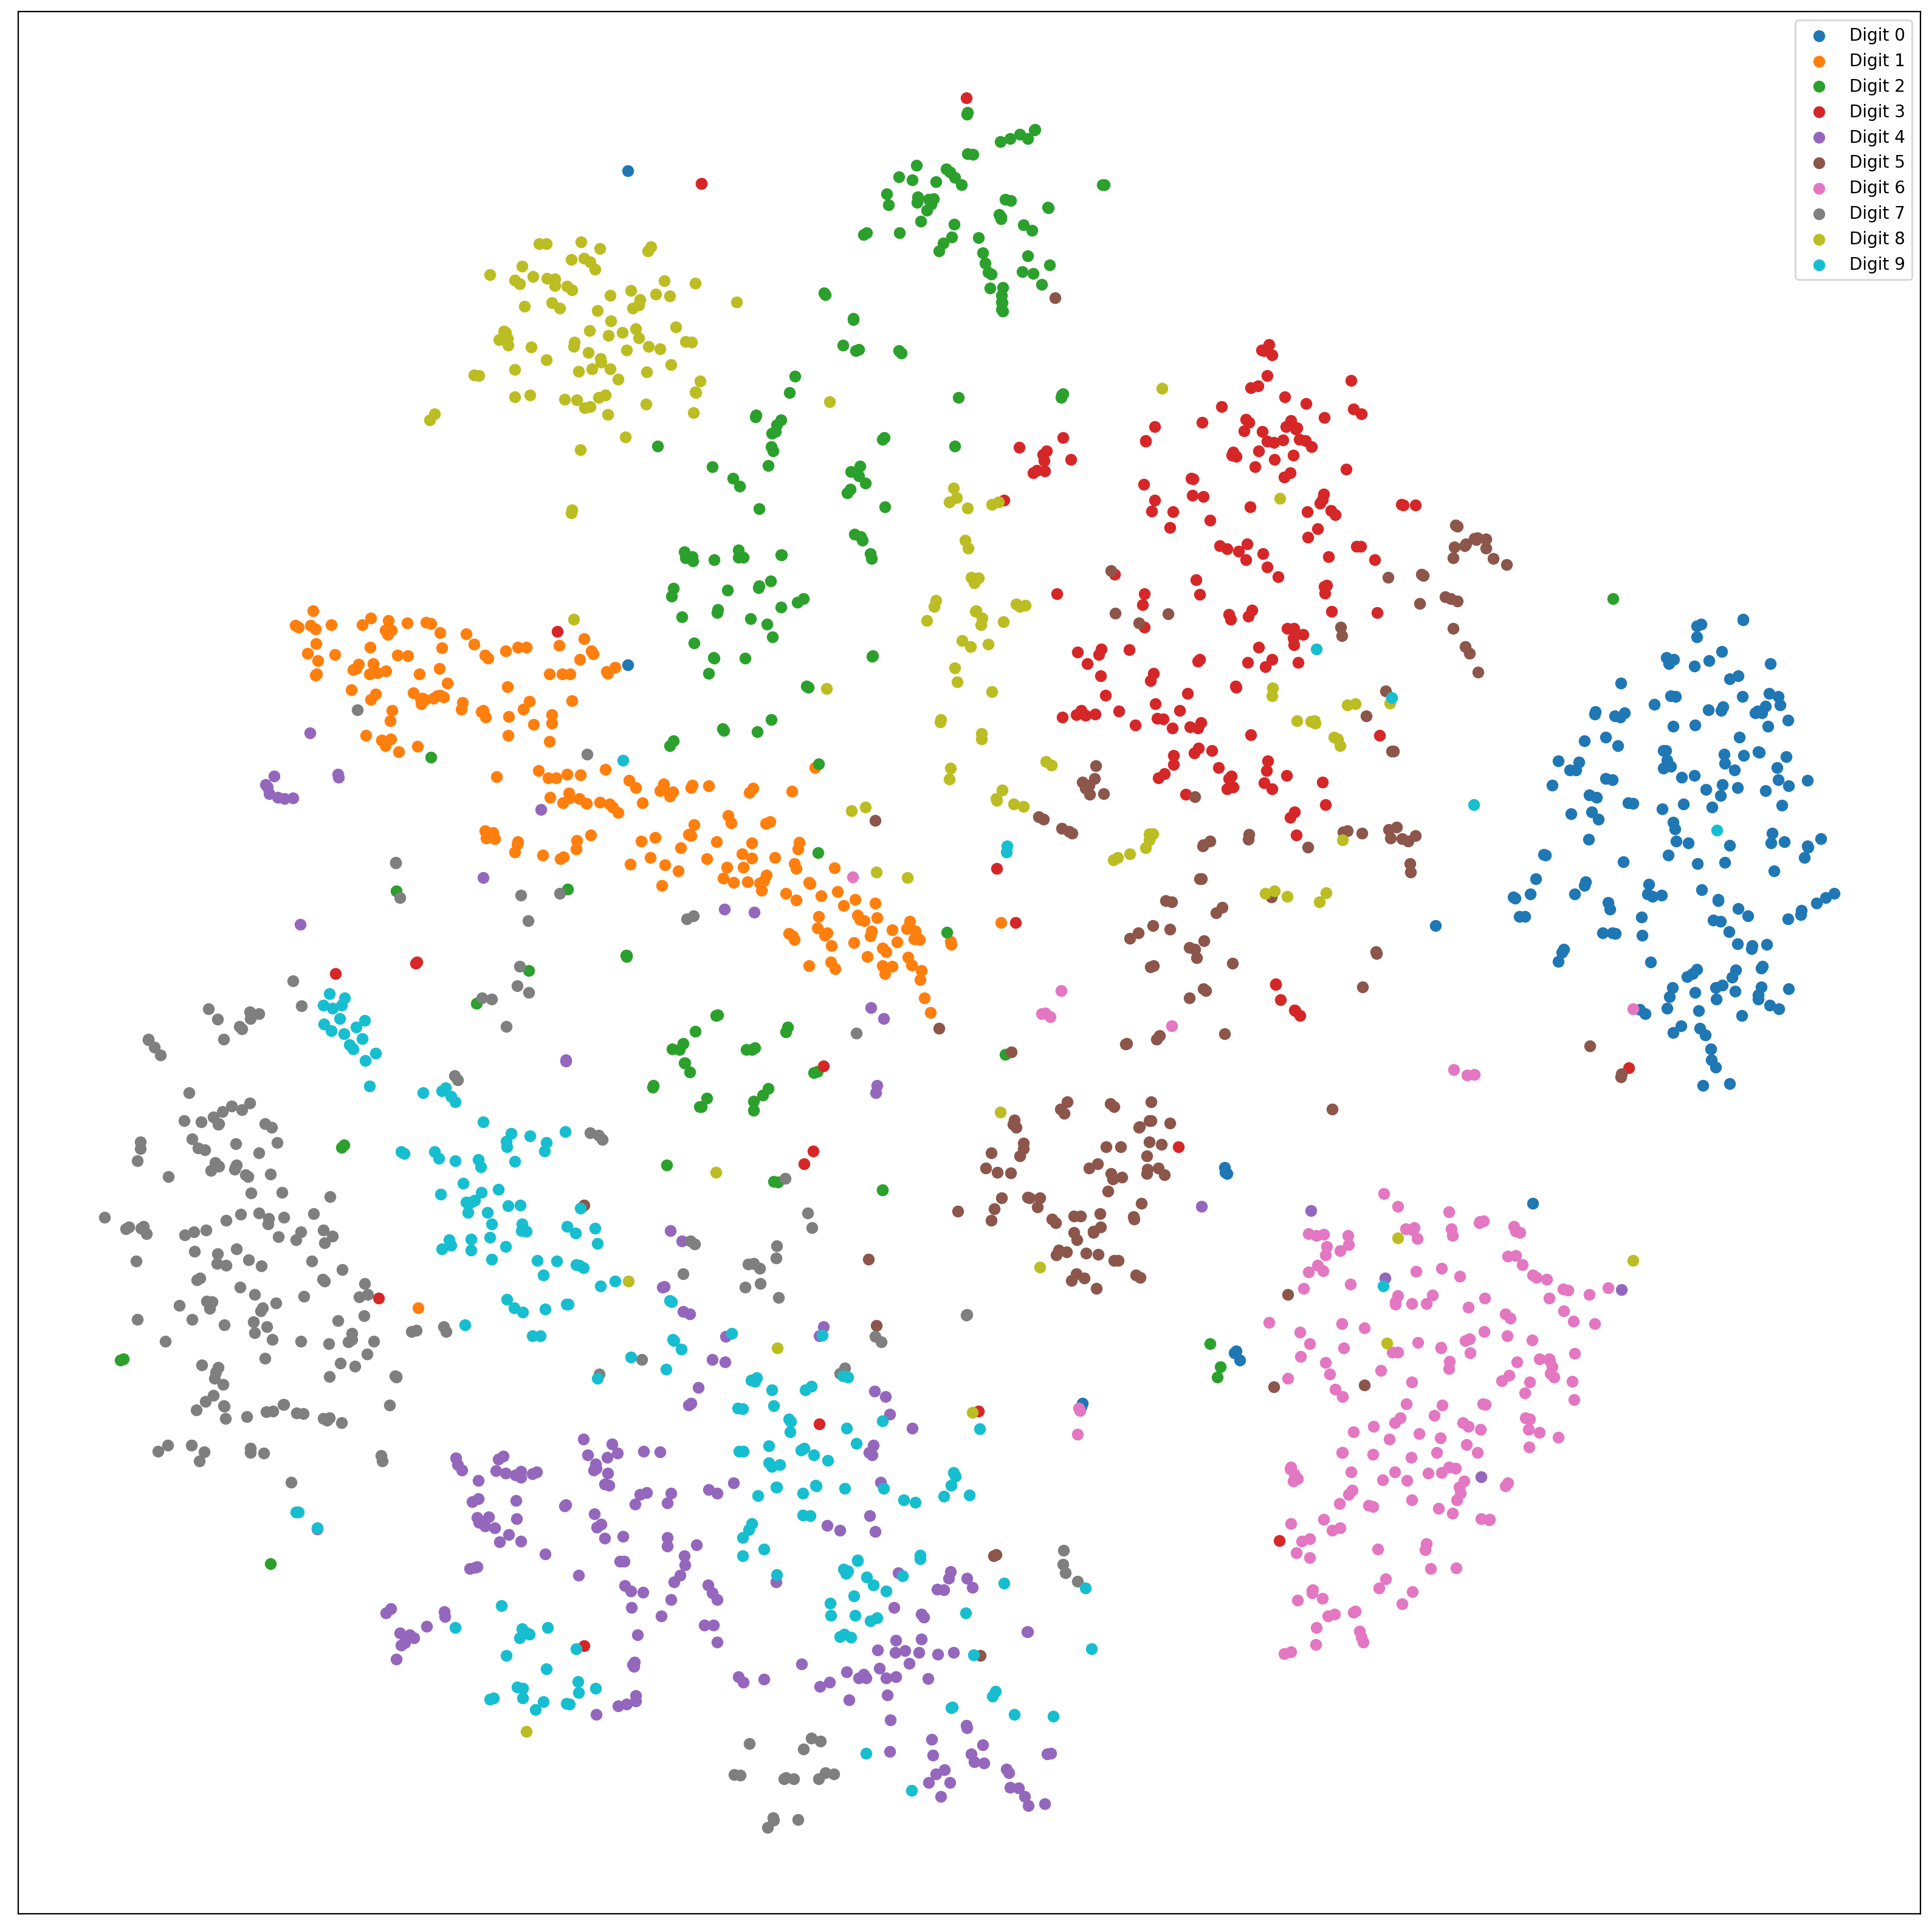

In [14]:
plot_2d_mnist_scatter(X_tsne_embedded, y_small)

### 3D interactive plots with plotly

In [23]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

def plot_3d_mnist_plotly_scatter(X, y):
    def make_trace(i):
        digit_indeces = y == i
        return go.Scatter3d(
            x=X[digit_indeces, 0],
            y=X[digit_indeces, 1],
            z=X[digit_indeces, 2],
            mode='markers',
            name=str(i),
            marker=dict(
                color=i,
                colorscale='Jet',
                size=4,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                )
            )
        )
        
    traces = [make_trace(i) for i in range(10)]

    #import plotly.io as pio
    #pio.renderers.default = 'iframe'
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

Use PCA function to embed `X_small` in **three** dimensions. Store the result in `X_3d_pca_embedded`.

In [24]:
pca_3d = PCA(n_components = 3)
X_3d_pca_embedded = pca_3d.fit_transform(X_small, y_small)


In [25]:
X_3d_pca_embedded.shape

(2000, 3)

In [26]:
plot_3d_mnist_plotly_scatter(X_3d_pca_embedded, y_small)

## Classification task

In [27]:
from sklearn.model_selection import train_test_split
SAMPLES_LIMIT=10000
X_train, X_test, y_train, y_test = train_test_split(X[:SAMPLES_LIMIT], y[:SAMPLES_LIMIT], test_size=0.2)

In [ ]:
from sklearn import svm
classifier = svm.SVC(C=1, gamma=0.001)
classifier.fit(X_train, y_train)

In [ ]:
from sklearn import metrics

predicted = classifier.predict(X_test)

print("Classification report for classifier {}:\n{}\n".format(
    classifier, metrics.classification_report(y_test, predicted)))

Calculate and display the confision matrix for `predicted` and `y_test` (use metrics package).

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print("Confusion matrix:\n{}".format(confusion_matrix))